# BEM-BEM coupling of Poisson-Boltzmann - spherical domain

## Solving problems for each of the mesh

In [1]:
from mpi4py import MPI 
from dolfinx.mesh import create_unit_cube
from dolfinx.fem import FunctionSpace

def poisson_boltzman_BEM_const(mesh):
    ######################### Mesh and spaces ##################################
    nor = ufl.FacetNormal(mesh) 
    
    # Spaces for FEM and BEM #
    fenics_space = FunctionSpace(mesh, ("Lagrange", 1))
    trace_space, trace_matrix = \
    fenicsx.fenics_to_bempp_trace_data(fenics_space)
    bempp_space = bempp.api.function_space(trace_space.grid, "P", 1)

    del fenics_space
    del trace_matrix

    # Mesh size information #
    print("BEM dofs: {0}".format(bempp_space.global_dof_count))
    hmax = trace_space.grid.maximum_element_diameter
    
    # Starting set-up time
    start = time.time()     
    
    # BEM operators #
    id_op = bempp.api.operators.boundary.sparse.identity(trace_space, trace_space, trace_space)
    mass = bempp.api.operators.boundary.sparse.identity(bempp_space, bempp_space, bempp_space)

    if fmm:
        dlp_0 = bempp.api.operators.boundary.laplace.double_layer(trace_space, trace_space, trace_space, assembler="fmm")
        slp_0 = bempp.api.operators.boundary.laplace.single_layer(bempp_space, trace_space, trace_space, assembler="fmm")
        adlp_0 = bempp.api.operators.boundary.laplace.adjoint_double_layer(bempp_space, bempp_space, bempp_space, assembler="fmm")
        hslp_0 = bempp.api.operators.boundary.laplace.hypersingular(trace_space, bempp_space, bempp_space, assembler="fmm")

        dlp = bempp.api.operators.boundary.modified_helmholtz.double_layer(trace_space, trace_space, trace_space, w, assembler="fmm")
        slp = bempp.api.operators.boundary.modified_helmholtz.single_layer(bempp_space, trace_space, trace_space, w, assembler="fmm")
        adlp = bempp.api.operators.boundary.modified_helmholtz.adjoint_double_layer(bempp_space, bempp_space, bempp_space, w, assembler="fmm")
        hslp = bempp.api.operators.boundary.modified_helmholtz.hypersingular(trace_space, bempp_space, bempp_space, w, assembler="fmm")
    else:
        dlp_0 = bempp.api.operators.boundary.laplace.double_layer(trace_space, trace_space, trace_space)
        slp_0 = bempp.api.operators.boundary.laplace.single_layer(bempp_space, trace_space, trace_space)
        adlp_0 = bempp.api.operators.boundary.laplace.adjoint_double_layer(bempp_space, bempp_space, bempp_space)
        hslp_0 = bempp.api.operators.boundary.laplace.hypersingular(trace_space, bempp_space, bempp_space)

        dlp = bempp.api.operators.boundary.modified_helmholtz.double_layer(trace_space, trace_space, trace_space, w)
        slp = bempp.api.operators.boundary.modified_helmholtz.single_layer(bempp_space, trace_space, trace_space, w)
        adlp = bempp.api.operators.boundary.modified_helmholtz.adjoint_double_layer(bempp_space, bempp_space, bempp_space, w)
        hslp = bempp.api.operators.boundary.modified_helmholtz.hypersingular(trace_space, bempp_space, bempp_space, w)
    
    RHS_in = bempp.api.GridFunction(trace_space, fun=RHS_M)
    RHS_out = bempp.api.GridFunction(bempp_space, fun=RHS_S)

    ######################### Matrix and RHS ##################################
    
    # RHS
    rhs_M = RHS_in.projections(trace_space)
    rhs_S = RHS_out.projections(bempp_space)
    rhs = np.concatenate([rhs_M, rhs_S])
    
    blocks = [[None,None],[None,None]]
    
    # Solvant case
    B00 = (.5*(1.+em/es)*id_op + (em/es*dlp_0 - dlp)).weak_form()
    B01 = -(slp_0-slp).weak_form()
    B10 = em/es*(hslp - hslp_0).weak_form()
    B11 = (.5*(1.+em/es)*mass - (adlp_0 - em/es*adlp)).weak_form()
    blocks[0][0] = B00  
    blocks[0][1] = B01  
    blocks[1][0] = B10  
    blocks[1][1] = B11  

    blocked = BlockedDiscreteOperator(np.array(blocks))
    
    ######################### Preconditioner and solvers ##################################
    # Mass matrix preconditioner #
    PM = InverseSparseDiscreteBoundaryOperator(
        bempp.api.operators.boundary.sparse.identity(
            bempp_space, bempp_space, bempp_space).weak_form())

    # Create a block diagonal preconditioner object using the Scipy LinearOperator class
    def apply_prec(x):
        """Apply the block diagonal preconditioner"""
        m1 = PM.shape[0]
        m2 = PM.shape[0]
        n1 = PM.shape[1]
        n2 = PM.shape[1]

        res1 = PM.dot(x[:n1])
        res2 = PM.dot(x[n1:])
        return np.concatenate([res1, res2])

    p_shape = (PM.shape[0] + PM.shape[0], PM.shape[1] + PM.shape[1])
    P = LinearOperator(p_shape, apply_prec, dtype=np.dtype('float64'))
        
    end = time.time()
    set_time = (end - start) 

    from scipy.sparse.linalg import gmres
    start = time.time()  
    soln, info = gmres(blocked, rhs, M=P, callback=count_iterations, tol=tol, restrt=500)  
    end = time.time()
    solv_time = (end - start) 
    
    soln_u = soln[:trace_space.global_dof_count]
    soln_lambda = soln[trace_space.global_dof_count:]
    
    dirichlet_fun = bempp.api.GridFunction(trace_space, coefficients=soln_u)
    neumann_fun = bempp.api.GridFunction(bempp_space, coefficients=es/em*soln_lambda)
    
    ######################### Solvation energy ##################################
    
    slpF = bempp.api.operators.potential.laplace.single_layer(bempp_space, np.transpose(PC)) 
    dlpF = bempp.api.operators.potential.laplace.double_layer(trace_space, np.transpose(PC))

    uF = slpF * neumann_fun - dlpF * dirichlet_fun
    
    q_uF = 0
    for i in range(len(PC)):
        Sum = (uF[0][i].real)*Q[i]
        q_uF = q_uF + Sum

    E_Solv = 0.5*4.*np.pi*332.064*(q_uF) 
    print('Energia de Solvatacion : {:7.3f} [kCal/mol]'.format(E_Solv))
    
    return E_Solv, hmax, it_count, set_time, solv_time

In [2]:
import dolfinx
import dolfinx.io
import dolfinx.geometry
from petsc4py import PETSc
import ufl
from scipy.sparse import csr_matrix

import bempp.api
from bempp.api.external import fenicsx
import numpy as np
from scipy.sparse.linalg import cg, minres
import pylab as plt
import time

from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import LinearOperator
from bempp.api.assembly.discrete_boundary_operator import InverseSparseDiscreteBoundaryOperator
from bempp.api.assembly.blocked_operator import BlockedDiscreteOperator

from bempp.api.operators.boundary import sparse, laplace, modified_helmholtz
from bempp.api.operators.potential import laplace as lp
 
# Solver data #
tol = 1e-05        # Tolerance
fmm = 0             # Use FMM

# Problem data #
Q = np.array([1.0,1.0,0.75])                           # Charges
PC=np.array([[1,0,0],[0.7,0.7,0],[-0.5,-0.5,0]])       # Points of charges
R = np.array([2., 2., 2.])                             # Radiuses
w = 0.1250                                             # kappa
es = 80.                                               # External permitivity (solvant)
em = 2.                                                # Internal permitivity (molecule)

ec = 1.602176e-19 #[C]
kb = 1.380648e-23 #[J/K]
T  = 300 #[K]
S1 = 1 #(ec/(kb*T))  #38.681 [C/J]

# Result collecting lists #
solv_error = []
mesh_size = []
iteration = []
time_solve = []
time_set = []

# Iteratotion for mesh #
grid_size = [0, 1, 2, 3]#, 4]#, 5, 6]
vertA2 = [2.31, 6.26, 21.13, 83.24]#, 315.03]

# Analytical solvation energy #
from an_solution import an_P
Rr = int(R[0])
G2 = an_P(Q, PC, em, es, Rr, w, Rr , 10)
print(G2)

# RHS functions #
@bempp.api.real_callable(jit=False)
def RHS_M(x, n, domain_index, result):
    global Q,PC,em,es,S1
    result[:] = (S1 / (4.*np.pi*es))  * np.sum( Q / np.linalg.norm( x - PC, axis=1))

@bempp.api.real_callable(jit=False)
def RHS_S(x, n, domain_index, result):
    global Q,PC,em,es,S1
    result[:] = -(S1/(4.*np.pi*es))   * np.sum( np.dot( x - PC , n)  * Q / (np.linalg.norm( x - PC , axis=1)**3) )

it_count = 0
def count_iterations(x):
    global it_count
    it_count += 1

bempp.api.set_logging_level(level='info')

for m in grid_size:
    ######################### Mesh and spaces ##################################
    mesh_file = "Sphere_R_"+format(Rr)+"_h_2_"+format(m)+"-converted.xdmf"
    with dolfinx.io.XDMFFile(MPI.COMM_WORLD, mesh_file, "r") as xdmf:
        mesh = xdmf.read_mesh(name="Grid")
        it_count = 0
        E_Solv, hmax, num_iter, set_time, solv_time = poisson_boltzman_BEM_const(mesh)
        time_set.append(set_time) 
        time_solve.append(solv_time)   
        bempp.api.log(
            "gmres finished in %i iterations and took %.2E sec." % (num_iter, solv_time))
        # print("Number of iterations: {0}".format(it_count))
        iteration.append(num_iter)
        mesh_size.append(hmax)
         
        #### Error calculation
        Error = np.abs( E_Solv/G2-1 )*100
        print('{:.4f}%'.format(Error))
        solv_error.append(Error)    

-336.03961985911303


INFO:bempp:Created grid with id 5a155371-8398-40b7-a87e-34d8a1cf9061. Elements: 228. Edges: 342. Vertices: 116


BEM dofs: 116


INFO:bempp:OpenCL CPU Device set to: pthread-AMD Ryzen Threadripper PRO 3975WX 32-Cores
  warn("Non-empty compiler output encountered. Set the "

  warn('splu converted its input to CSC format', SparseEfficiencyWarning)

INFO:bempp:gmres finished in 5 iterations and took 3.21E-03 sec.
INFO:bempp:Created grid with id 7fcc8f94-430b-4108-996e-1240f1afbec7. Elements: 628. Edges: 942. Vertices: 316


Energia de Solvatacion : -343.358 [kCal/mol]
2.1777%
BEM dofs: 316


INFO:bempp:gmres finished in 5 iterations and took 6.49E-03 sec.
INFO:bempp:Created grid with id 6e277196-a0ff-485d-a79e-b106412a222e. Elements: 2120. Edges: 3180. Vertices: 1062


Energia de Solvatacion : -338.503 [kCal/mol]
0.7330%
BEM dofs: 1062


INFO:bempp:gmres finished in 5 iterations and took 1.72E-02 sec.


Energia de Solvatacion : -336.792 [kCal/mol]
0.2239%


INFO:bempp:Created grid with id 32edadaa-58f4-4176-9d32-f9d489a0c886. Elements: 8364. Edges: 12546. Vertices: 4184


BEM dofs: 4184


INFO:bempp:gmres finished in 5 iterations and took 1.66E-01 sec.


Energia de Solvatacion : -336.223 [kCal/mol]
0.0545%


## Ploting the results in comparison to FEM-BEM coupling formulations

## Convergence plot

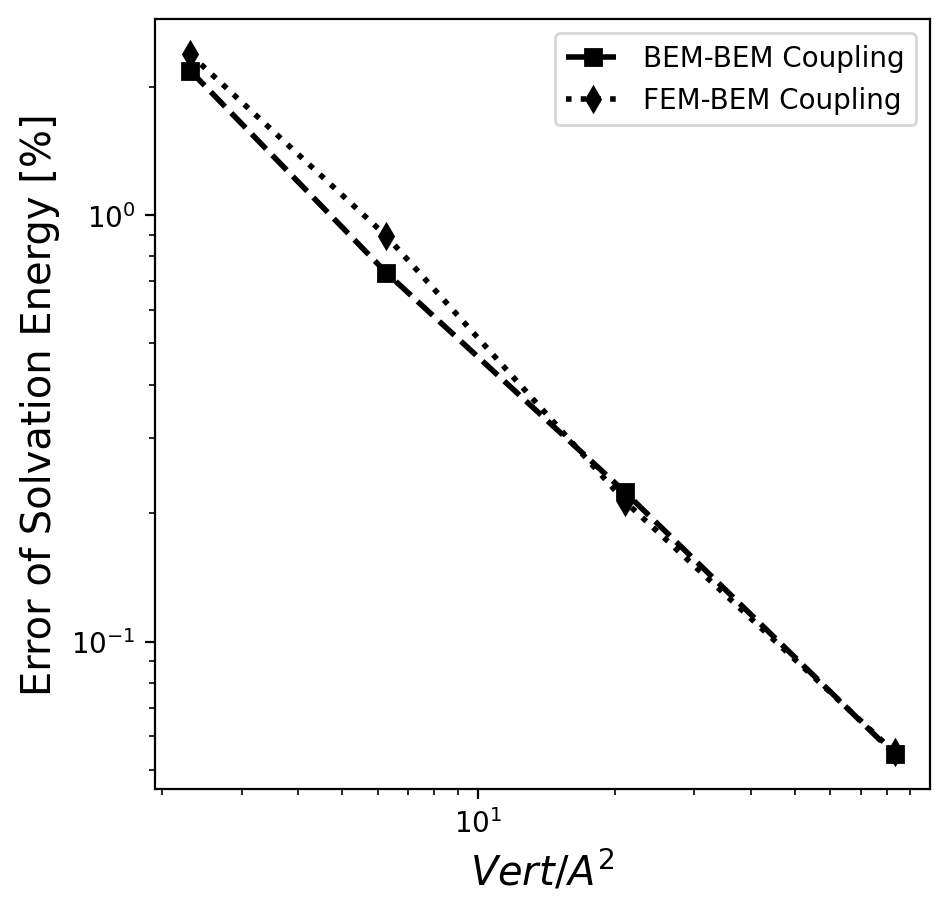

In [3]:
from operator import add
import matplotlib.pyplot as plt

with open('FEM_BEM_Sphere_Const_error.npy', 'rb') as f:
     FEM_BEM_solv_error = np.load(f)

# with open('Hybrid_FEM_BEM_Sphere_Const_error.npy', 'rb') as f:
#      Hybrid_FEM_BEM_solv_error = np.load(f)

plt.figure( figsize=(5, 5), dpi=200)
plt.loglog(vertA2, solv_error, 'ks--', linewidth=2, label='BEM-BEM Coupling')
plt.loglog(vertA2, FEM_BEM_solv_error, 'kd:', linewidth=2, label='FEM-BEM Coupling')
# plt.loglog(mesh_size, Hybrid_FEM_BEM_solv_error, 'ko-.', linewidth=2, label='Hybrid FEM-BEM Coupling')
# plt.loglog(mesh_size, o_mesh_size, 'k:', linewidth=1, label='O(h)')
plt.legend(loc='best')
# plt.title('Sphere and constant coefficient')
# plt.xlabel('Mesh size', fontsize='x-large')
plt.xlabel('$Vert/A^2$', fontsize='x-large')
plt.ylabel('Error of Solvation Energy [%]', fontsize='x-large')
plt.show()

## Iteration count

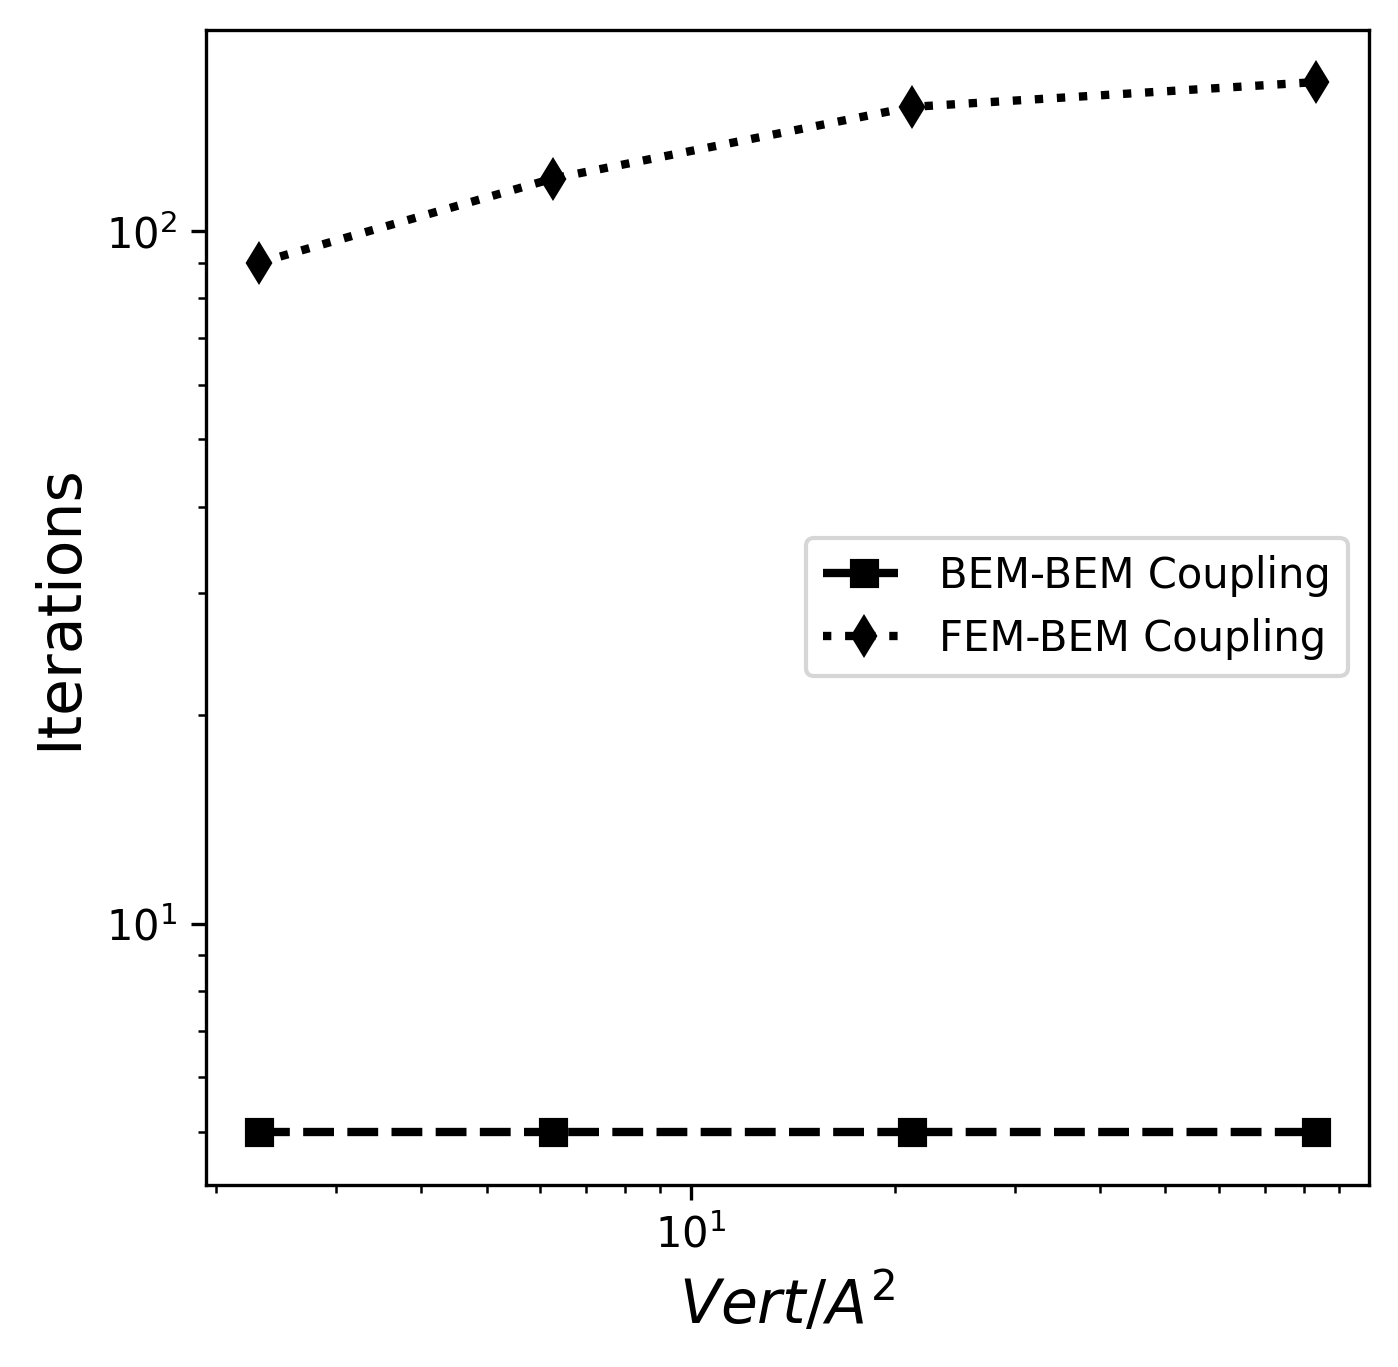

In [4]:
# log_mesh_size = np.log(mesh_size)

with open('FEM_BEM_Sphere_Const_iter.npy', 'rb') as f:
     FEM_BEM_solv_iter = np.load(f)

# with open('Hybrid_FEM_BEM_Sphere_Const_iter.npy', 'rb') as f:
#      Hybrid_FEM_BEM_solv_iter = np.load(f)

plt.figure( figsize=(5, 5), dpi=300)
plt.loglog(vertA2, iteration, 'ks--', linewidth=2, label='BEM-BEM Coupling')
plt.loglog(vertA2, FEM_BEM_solv_iter, 'kd:', linewidth=2, label='FEM-BEM Coupling')
# plt.loglog(mesh_size, Hybrid_FEM_BEM_solv_iter, 'ko-.', linewidth=2, label='Hybrid FEM-BEM Coupling')
plt.legend(loc='best')
# plt.title('Sphere and constant coefficient')
# plt.xlabel('Mesh size', fontsize='x-large')
plt.xlabel('$Vert/A^2$', fontsize='x-large')
plt.ylabel('Iterations', fontsize='x-large')
plt.show()

## Computational cost

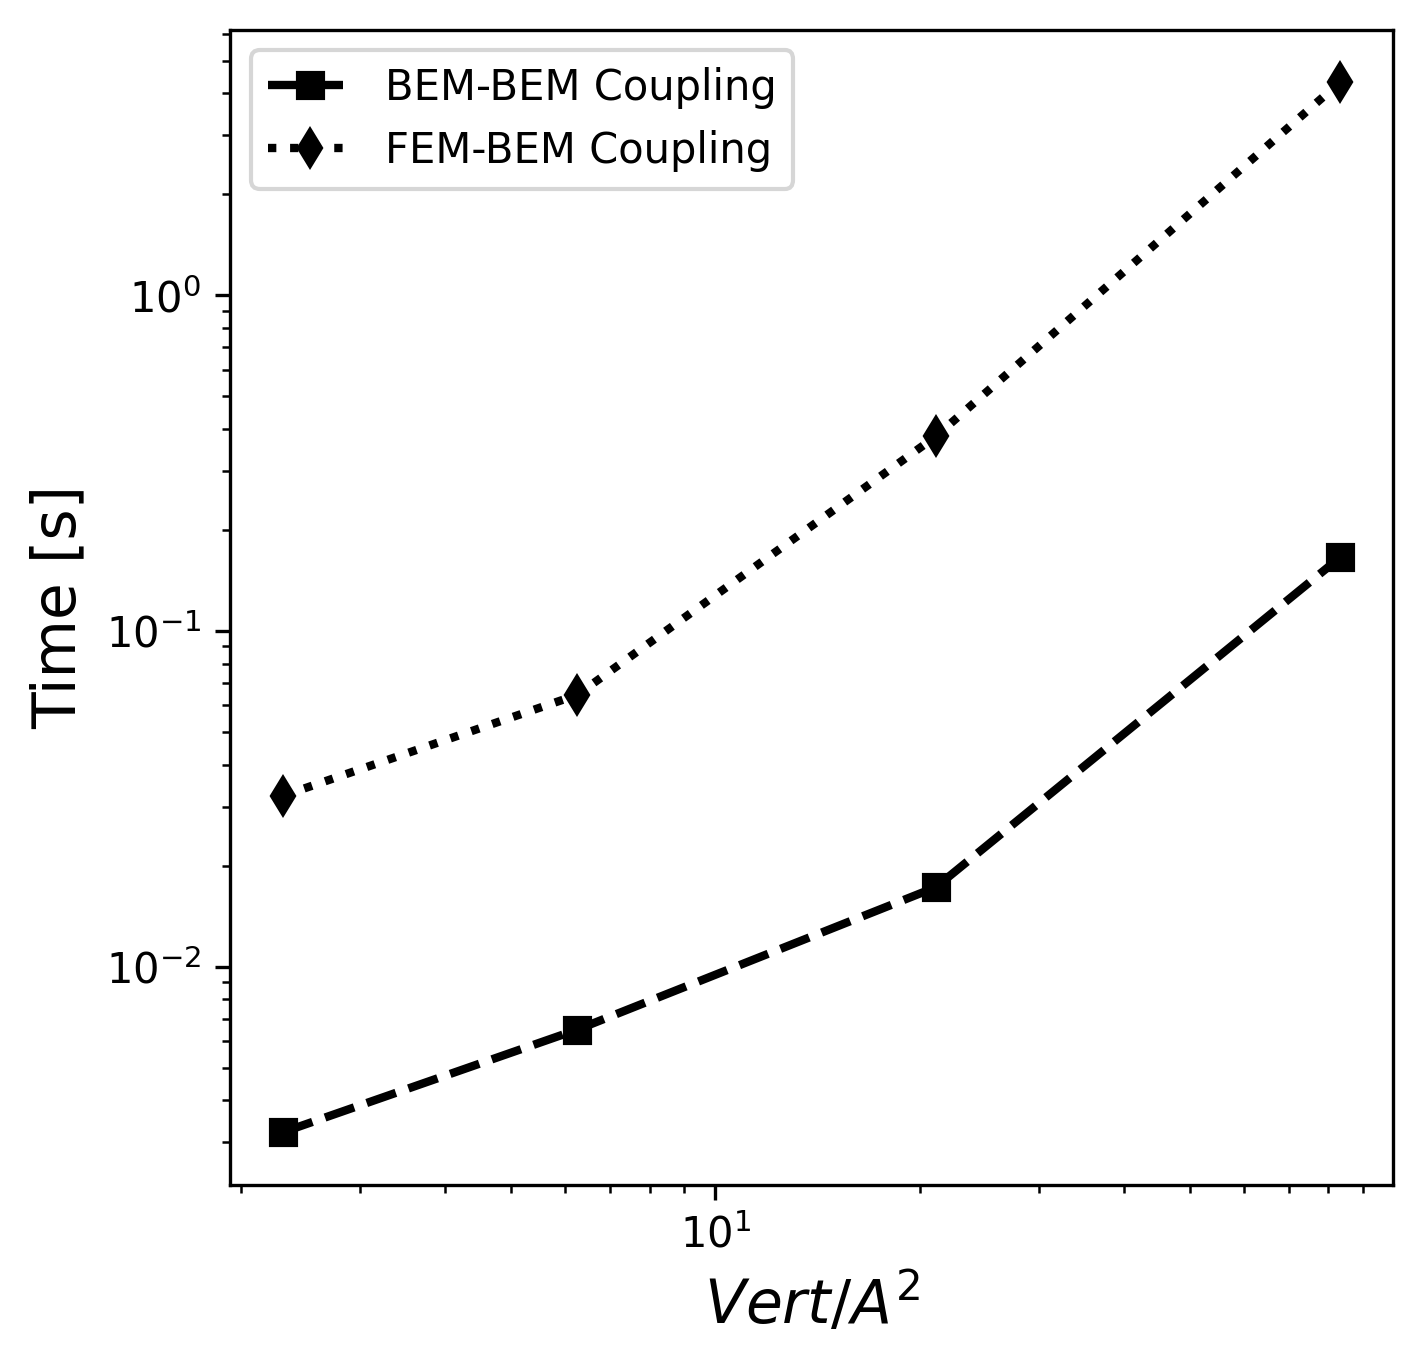

In [5]:
log_mesh_size = np.log(mesh_size)

with open('FEM_BEM_Sphere_Const_time.npy', 'rb') as f:
     FEM_BEM_solv_time = np.load(f)

# with open('Hybrid_FEM_BEM_Sphere_Const_time.npy', 'rb') as f:
#      Hybrid_FEM_BEM_solv_time = np.load(f)

plt.figure( figsize=(5, 5), dpi=300)
plt.loglog(vertA2, time_solve, 'ks--', linewidth=2, label='BEM-BEM Coupling')
plt.loglog(vertA2, FEM_BEM_solv_time, 'kd:', linewidth=2, label='FEM-BEM Coupling')
# plt.loglog(mesh_size, Hybrid_FEM_BEM_solv_time, 'ko-.', linewidth=2, label='Hybrid FEM-BEM Coupling')
plt.legend(loc='best')
# plt.title('Sphere and constant coefficient')
# plt.xlabel('Mesh size', fontsize='x-large')
plt.xlabel('$Vert/A^2$', fontsize='x-large')
plt.ylabel('Time [s]', fontsize='x-large')
plt.show()

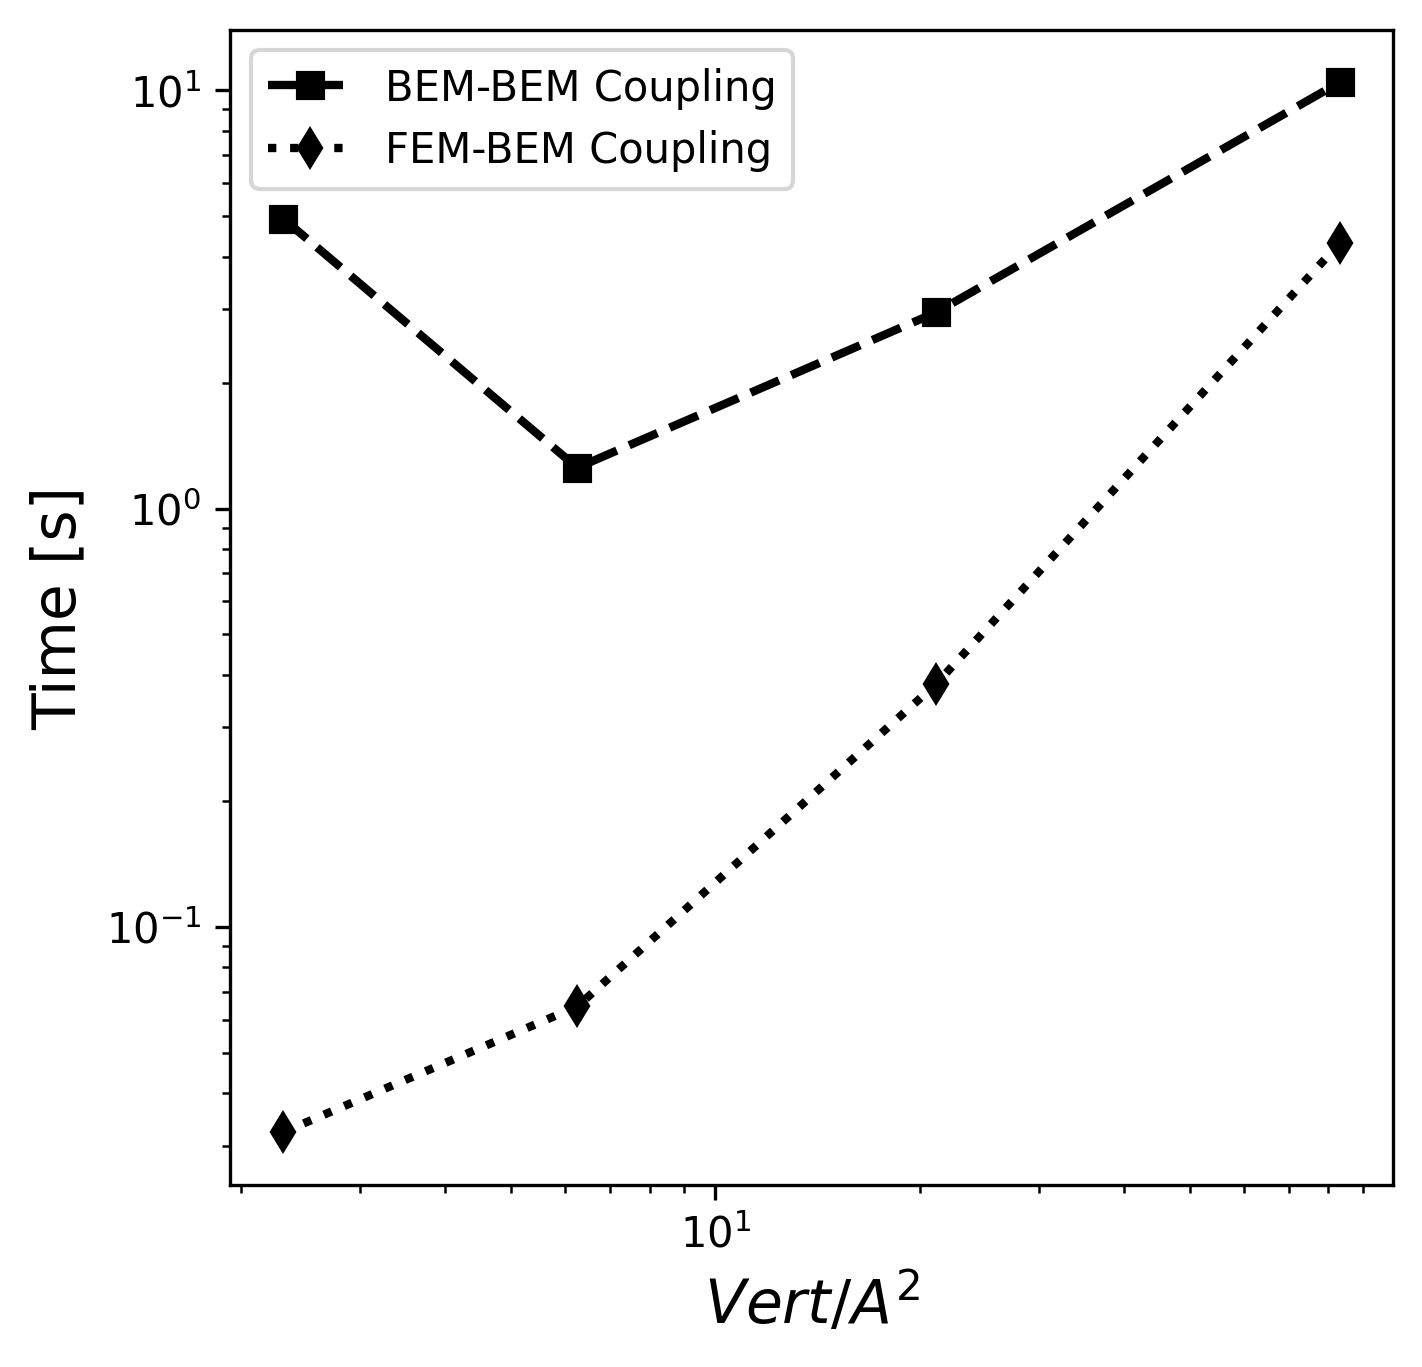

In [6]:
log_mesh_size = np.log(mesh_size)

with open('FEM_BEM_Sphere_Const_time_assemble.npy', 'rb') as f:
     FEM_BEM_solv_time = np.load(f)

# with open('Hybrid_FEM_BEM_Sphere_Const_time_assemble.npy', 'rb') as f:
#      Hybrid_FEM_BEM_solv_time = np.load(f)

plt.figure( figsize=(5, 5), dpi=300)
plt.loglog(vertA2, time_set, 'ks--', linewidth=2, label='BEM-BEM Coupling')
plt.loglog(vertA2, FEM_BEM_solv_time, 'kd:', linewidth=2, label='FEM-BEM Coupling')
# plt.loglog(mesh_size, Hybrid_FEM_BEM_solv_time, 'ko-.', linewidth=2, label='Hybrid FEM-BEM Coupling')
plt.legend(loc='best')
# plt.title('Sphere and constant coefficient')
# plt.xlabel('Mesh size', fontsize='x-large')
plt.xlabel('$Vert/A^2$', fontsize='x-large')
plt.ylabel('Time [s]', fontsize='x-large')
plt.show()